In [1]:
get_ipython().run_cell_magic('capture', '', "%logstop\n%logstart -t -r -q ipython_command_log.py global\n\n#- IRONHACKS RESEARCH TRACKING CODE\n#----------------------------------\n# The following code is used to help our research team understand how you \n# our notebook environment. We do not collect any personal information with\n# the following code, it is used to measure when and how often you work on\n# your submission files.\n\nimport os\nfrom datetime import datetime\nimport IPython.core.history as history\n\nha = history.HistoryAccessor()\nha_tail = ha.get_tail(1)\nha_cmd = next(ha_tail)\nsession_id = str(ha_cmd[0])\ncommand_id = str(ha_cmd[1])\ntimestamp = datetime.utcnow().isoformat()\nhistory_line = ','.join([session_id, command_id, timestamp]) + '\\n'\nlogfile = open(os.environ['HOME']+'/ipython_session_log.csv', 'a')\nlogfile.write(history_line)\nlogfile.close()\n")

In [2]:
get_ipython().run_cell_magic('capture', '', "#- INSTALL ADDITIONAL LIBRARIES IF REQUIRED\n#------------------------------------------\n# This is normally not required. The hub environment comes preinstaled with \n# many packages that you can already use without setup. In case there is some\n# other library you would like to use that isn't on the list you run this command\n# once to install them.  If it is already installed this command has no effect.\n!pip install google-cloud-bigquery\n!pip install google-cloud-bigquery[pandas]\n")

In [3]:
#- IMPORT THE LIBRARIES YOU WILL USE
#------------------------------------------
# You only need to import packages one time per notebook session. To keep your
# notebook clean and organized you can handle all imports at the top of your file.
# The following are included for example purposed, feel free to modify or delete 
# anything in this section.
import csv
import pandas as pd
import numpy as np
import random as rand
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [4]:
BIGQUERY_PROJECT = 'ironhacks-data'
bigquery_client = bigquery.Client(project=BIGQUERY_PROJECT)

In [5]:
#query 1: overview of employment_data(week 41)
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.unemployment_data`
ORDER BY week_number ASC;
"""
query_job = bigquery_client.query(query)
overview = query_job.to_dataframe()
overview.head()

,uu_id,timeperiod,week_number,countyfips,tract,tract_name,total_claims,edu_8th_or_less,edu_grades_9_11,edu_hs_grad_equiv,...,gender_female,gender_male,gender_na,race_amerindian,race_asian,race_black,race_noanswer,race_hawaiiannative,race_other,race_white
0,65f24aac652de33abaf3f227b41e2641,20220101,1,18093,950500,"Census Tract 9505, Lawrence County, Indiana",10,0,<NA>,<NA>,...,<NA>,<NA>,0,0,0,<NA>,0,0,0,<NA>
1,14ceb8012cb1b912044297c8933cfcfc,20220101,1,18057,110506,"Census Tract 1105.06, Hamilton County, Indiana",39,<NA>,0,<NA>,...,<NA>,<NA>,0,0,0,<NA>,<NA>,0,<NA>,28
2,f013068de98db1470bd986137a0c6d23,20220101,1,18003,900,"Census Tract 9, Allen County, Indiana",10,0,0,<NA>,...,<NA>,<NA>,0,0,0,<NA>,0,0,<NA>,<NA>
3,f70960d492c2fd067680a14baa0f66e9,20220101,1,18167,10600,"Census Tract 106, Vigo County, Indiana",35,0,<NA>,21,...,<NA>,<NA>,0,0,0,0,<NA>,0,<NA>,32
4,778946d9696cd6c95f57e8b1e6336389,20220101,1,18167,11200,"Census Tract 112, Vigo County, Indiana",37,0,<NA>,24,...,26,11,0,0,0,<NA>,<NA>,0,<NA>,<NA>


In [6]:
#query 2: overview of important info from unemployment table
query = """
SELECT uu_id, week_number, total_claims
FROM `ironhacks-data.ironhacks_competition.unemployment_data` 
ORDER BY week_number ASC
"""
query_jobb = bigquery_client.query(query)
employ = query_jobb.to_dataframe()
print(employ.head())

                              uu_id  week_number  total_claims
0  65f24aac652de33abaf3f227b41e2641            1            10
1  14ceb8012cb1b912044297c8933cfcfc            1            39
2  f013068de98db1470bd986137a0c6d23            1            10
3  f70960d492c2fd067680a14baa0f66e9            1            35
4  778946d9696cd6c95f57e8b1e6336389            1            37


In [7]:
#query 3: overview of prediction list (week 41)
query = """
SELECT *
FROM `ironhacks-data.ironhacks_competition.prediction_list`
"""
query_job = bigquery_client.query(query)
predn = query_job.to_dataframe()
predn.head()
print(predn.head())

                              uu_id  week_number
0  5bf51fc2e162d6faf9e3cf79e4198378           44
1  420b44cc7e3f55d738df565421e59941           44
2  e39c66ecceec76ee8f9f811fa4a2d246           44
3  a90462cd11ae4e43144239bf7c4828a4           44
4  8b20a6749088c7ff1237983076ebfeaa           44


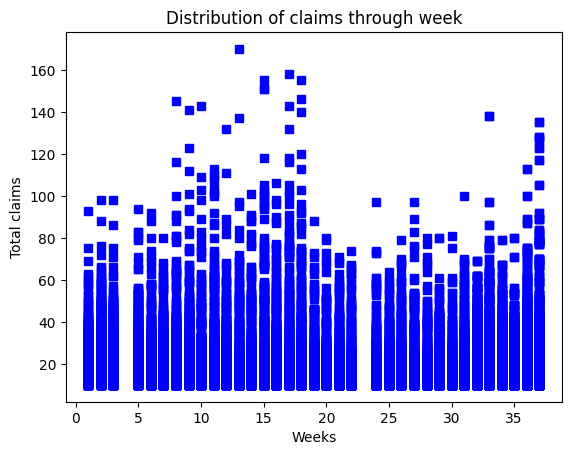

In [8]:
fig = plt.figure()
plt.plot([employ.week_number], [employ.total_claims],'bs')
plt.title('Distribution of claims through week')
plt.xlabel('Weeks')
plt.ylabel('Total claims')
plt.show()

In [9]:
#Calculate average number of claims/ rates of change/ estimated errors (week 30-37)
employ['avg'] = (sum(employ['total_claims'])/len(employ['total_claims']))
employ['error'] = ((employ['total_claims']-employ['avg'])/employ['avg'])
employ['avgError'] = (employ['error']/len(employ['total_claims']))
avgError = (employ['error']/len(employ['total_claims']))
avgError = avgError.drop_duplicates()
l = employ[['week_number','total_claims','avg','error','avgError']]
print(l)

       week_number  total_claims        avg     error  avgError
0                1            10  22.952712 -0.564322 -0.000034
1                1            39  22.952712  0.699146  0.000042
2                1            10  22.952712 -0.564322 -0.000034
3                1            35  22.952712  0.524874  0.000031
4                1            37  22.952712   0.61201  0.000036
...            ...           ...        ...       ...       ...
16828           37            10  22.952712 -0.564322 -0.000034
16829           37            13  22.952712 -0.433618 -0.000026
16830           37            13  22.952712 -0.433618 -0.000026
16831           37            11  22.952712 -0.520754 -0.000031
16832           37            11  22.952712 -0.520754 -0.000031

[16833 rows x 5 columns]


In [10]:
labels = np.array(overview['total_claims'])
features = employ.drop(['uu_id'], axis=1)
feature_list = list(features.columns)
features = np.array(features)

In [11]:
#split data into train and test sets, split first 20% data
x_train, x_test, y_train,y_test = train_test_split(features, labels, test_size = 0.15, random_state = 42)

In [12]:
print(f'Training Features Shape: {x_train.shape}')
print(f'Testing Features Shape: {x_test.shape}')
print(f'Training Labels Shape: {y_train.shape}')
print(f'Testing Labels Shape: {y_test.shape}')

Training Features Shape: (14308, 5)
Testing Features Shape: (2525, 5)
Training Labels Shape: (14308,)
Testing Labels Shape: (2525,)


In [13]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=1000, random_state=42)
x = x_train
y = y_train
regressor.fit(x,y) 

RandomForestRegressor(n_estimators=1000, random_state=42)

[Text(0.3403716216216216, 0.95, 'x[1] <= 34.5\nsquared_error = 210.671\nsamples = 9033\nvalue = 22.674'),
 Text(0.10067567567567567, 0.85, 'x[1] <= 19.5\nsquared_error = 40.49\nsamples = 7737\nvalue = 18.089'),
 Text(0.043243243243243246, 0.75, 'x[1] <= 14.5\nsquared_error = 7.756\nsamples = 4926\nvalue = 14.017'),
 Text(0.021621621621621623, 0.65, 'x[4] <= -0.0\nsquared_error = 1.984\nsamples = 2822\nvalue = 11.965'),
 Text(0.010810810810810811, 0.55, 'x[3] <= -0.543\nsquared_error = 0.25\nsamples = 1155\nvalue = 10.503'),
 Text(0.005405405405405406, 0.45, 'squared_error = 0.0\nsamples = 576\nvalue = 10.0'),
 Text(0.016216216216216217, 0.45, 'squared_error = 0.0\nsamples = 579\nvalue = 11.0'),
 Text(0.032432432432432434, 0.55, 'x[4] <= -0.0\nsquared_error = 0.682\nsamples = 1667\nvalue = 12.976'),
 Text(0.02702702702702703, 0.45, 'squared_error = 0.0\nsamples = 579\nvalue = 12.0'),
 Text(0.03783783783783784, 0.45, 'x[3] <= -0.412\nsquared_error = 0.25\nsamples = 1088\nvalue = 13.509')

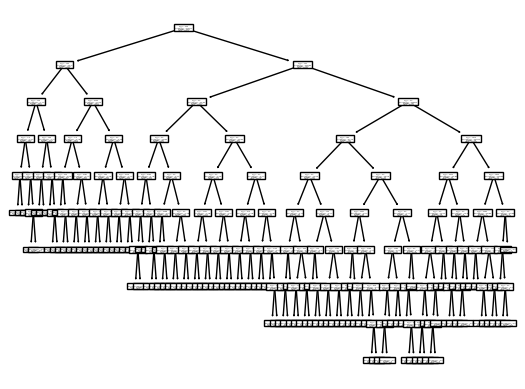

In [14]:
#visualizing the decision tree from the regressor
from sklearn import tree
tree.plot_tree(regressor.estimators_[0])

In [15]:
predictions = regressor.predict(x_test).astype(int)
predictions = np.round(predictions,decimals = 0, out = None)
print(predictions)

[15 25 21 ... 18 18 16]


In [16]:
errors = abs(y_test - predictions)
print(f'List of Errors: {errors}')
print(f'Mean Absolute Error: {np.mean(errors)*10:.4f}%')

List of Errors: [0 0 0 ... 0 0 0]
Mean Absolute Error: 0.0911%


as the mean absolute error is less than 10%, we could take prediction as final outcome.

In [17]:
df = pd.DataFrame(predictions, columns=['total_claims'])
week44 = predn.join(df).iloc[:,[0,2,1]]
print(week44)
print(f'Total predicting number of unemployment claims of week 44: {sum(predictions):.0f}')

                                uu_id  total_claims  week_number
0    5bf51fc2e162d6faf9e3cf79e4198378            15           44
1    420b44cc7e3f55d738df565421e59941            25           44
2    e39c66ecceec76ee8f9f811fa4a2d246            21           44
3    a90462cd11ae4e43144239bf7c4828a4            20           44
4    8b20a6749088c7ff1237983076ebfeaa            26           44
..                                ...           ...          ...
520  46c4f6c75e663b1ca82ea7994e6d83d3            56           44
521  1deebda501712e7595b531b8337bc31a            16           44
522  5a9758f65f001b6432ff31ff64a459d7            19           44
523  e8b3b95e93a6dc7dbb90f4e72e7ac065            32           44
524  932a58530abff8a48558e2a15639d453            35           44

[525 rows x 3 columns]
Total predicting number of unemployment claims of week 44: 58978


In [18]:
csv_data = week44.to_csv("submission_prediction_output.csv",index=False)

In [19]:
predictions = regressor.predict(x_test).astype(int)
predictions = np.round(predictions,decimals = 0, out = None)
predictions = predictions + avgError
print(predictions)

ValueError: operands could not be broadcast together with shapes (2525,) (120,) 

In [20]:
predictions = regressor.predict(x_test).astype(int)
predictions = np.round(predictions,decimals = 0, out = None)
predictions = predictions + avgError^21
print(predictions)

ValueError: operands could not be broadcast together with shapes (2525,) (120,) 

In [21]:
#Calculate average number of claims/ rates of change/ estimated errors (week 30-37)
employ['avg'] = (sum(employ['total_claims'])/len(employ['total_claims']))
employ['error'] = ((employ['total_claims']-employ['avg'])/employ['avg'])
employ['avgError'] = (employ['error']/len(employ['total_claims']))
avgError = (employ['error']/len(employ['total_claims']))
avgError = avgError.drop_duplicates()
avgError = avgError/len(avgError)
l = employ[['week_number','total_claims','avg','error','avgError']]
print(l)

       week_number  total_claims        avg     error  avgError
0                1            10  22.952712 -0.564322 -0.000034
1                1            39  22.952712  0.699146  0.000042
2                1            10  22.952712 -0.564322 -0.000034
3                1            35  22.952712  0.524874  0.000031
4                1            37  22.952712   0.61201  0.000036
...            ...           ...        ...       ...       ...
16828           37            10  22.952712 -0.564322 -0.000034
16829           37            13  22.952712 -0.433618 -0.000026
16830           37            13  22.952712 -0.433618 -0.000026
16831           37            11  22.952712 -0.520754 -0.000031
16832           37            11  22.952712 -0.520754 -0.000031

[16833 rows x 5 columns]


In [22]:
predictions = regressor.predict(x_test).astype(int)
predictions = np.round(predictions,decimals = 0, out = None)
predictions = predictions + avgError
print(predictions)

ValueError: operands could not be broadcast together with shapes (2525,) (120,) 

In [23]:
predictions = regressor.predict(x_test).astype(int)
predictions = np.round(predictions,decimals = 0, out = None)
predictions = predictions*(1-avgError)
print(predictions)

ValueError: operands could not be broadcast together with shapes (2525,) (120,) 